<h1>
    Q.1 Modeling 
</h1>

<h3>Skill:</h3>
<ul>
    <li>Player 1 skill: $s_1$</li>
    <li>Player 2 skill: $s_2$</li>
</ul>
Where: $s_1 \sim \mathcal{N}(\mu_1,\,\sigma^{2}_1)$

Where: $s_2 \sim \mathcal{N}(\mu_2,\,\sigma^{2}_2)$

<h3>Game outcome:</h3>
<ul>
    <li>$t = s_1 - s_2$</li>
</ul>
Where: $t \sim \mathcal{N}(\mu_t = s_1 - s_2,\,\sigma^{2}_t)$

<h3>Game result:</h3>
<ul>
    <li>If player 1 wins: $y = 1$</li>
    <li>If player 2 wins: $y = -1$</li>
</ul>

<h3>Bayesian model:</h3>
<ul>
    <li>$P(s_1, s_2, t, y) = P(y|t) \cdot P(t|s_1, s_2) \cdot P(s_1) \cdot P(s_2)$</li>
</ul>
Where: 
<ul>
    <li>$P(y|t)$ Game result given game outcome</li>
    <li>$P(t|s_1, s_2)$ Game outcome given player skills</li>
    <li>$P(s_1)$ and $P(s_2)$ Player skill priors</li>
</ul>

<h3>Hyperparameters:</h3>
<ul>
    <li>Player 1: $\mu_1$ and $\sigma^{2}_1$</li>
    <li>Player 2: $\mu_2$ and $\sigma^{2}_2$</li>
    <li>Unpredictability of the game outcome: $\sigma^{2}_t$</li>
</ul>

<h1>
    Q.2 Bayesian Network
</h1>

$s_1$ and $s_2$ influences $t$ 

$t$ then influences $y$

<h1>
    Q.3 Computing with the model
</h1>

In [76]:
import numpy as np
from scipy.stats import norm
from scipy.stats import truncnorm

<h3>Initialization</h3>

In [77]:
def initialize_parameters():
    return {
        "mean_s1": 1,
        "var_s1": 1,
        "mean_s2": -1,
        "var_s2": 4,
        "var_t": 5,
        "t_obs": 3
    }
params = initialize_parameters()

<h3>$p(s1, s2|t, y)$ - Full conditional distribution of the skills</h3>

In [78]:
# Gaussian-Gaussian Bayesian Update
def update_skills(mean_s1, var_s1, mean_s2, var_s2, var_t, t_obs):
    A = np.array([[1, -1]])
    mu_prior = np.array([[mean_s1], [mean_s2]])
    Sigma_prior = np.array([[var_s1, 0], [0, var_s2]])

    Sigma_posterior = np.linalg.inv(np.linalg.inv(Sigma_prior) + (A.T / var_t) @ A)
    mu_posterior = Sigma_posterior @ (np.linalg.inv(Sigma_prior) @ mu_prior + (A.T / var_t) @ np.array([[t_obs]]))

    return mu_posterior.flatten(), Sigma_posterior

mu_posterior, Sigma_posterior = update_skills(**params)
print("Posterior mean of s1 and s2:", mu_posterior)
print("Posterior covariance of s1 and s2:", Sigma_posterior)

Posterior mean of s1 and s2: [ 1.1 -1.4]
Posterior covariance of s1 and s2: [[0.9 0.4]
 [0.4 2.4]]


<h3>$p(t|s1, s2, y)$ - Full conditional distribution of the outcome</h3>

In [79]:
def conditional_distribution_t(s1, s2, y, var_t):
    """
    Compute parameters of the truncated Gaussian distribution p(t|s1, s2, y).
    """
    
    # Mean and variance for the Gaussian p(t|s1, s2)
    mu_t = s1 - s2
    sigma_t = var_t
    
    # Determine truncation bounds based on game result
    a, b = (-np.inf, 0) if y == -1 else (0, np.inf)

    return mu_t, sigma_t, a, b

s1_val, s2_val, y_val = 2, 1, 1
mu, sigma, a, b = conditional_distribution_t(s1_val, s2_val, y_val, params['var_t'])
print(f"Parameters for p(t|s1, s2, y):\nmu_t: {mu}, sigma^2: {round(sigma,4)} \nBounds: [{a}, {b}]")

Parameters for p(t|s1, s2, y):
mu_t: 1, sigma^2: 5 
Bounds: [0, inf]


<h3>$p(y=1)$ - Marginal probability that Player 1 wins the game</h3>

In [80]:
# Marginal Probability that Player 1 Wins
def compute_marginal_probability(mu_t, var_s1, var_s2, var_t):
    sigma_t = np.sqrt(var_s1 + var_s2 + var_t)
    probability_y1 = 1 - norm.cdf(0, mu_t, sigma_t)
    
    return probability_y1

mu_t = 2

prob_y1 = compute_marginal_probability(mu_t, params['var_s1'], params['var_s2'], params['var_t'])
print(f"Marginal probability that Player 1 wins (p(y=1)): {round(prob_y1,4)}")
print(f"Marginal probability that Player 2 wins (p(y=-1)): {round(1-prob_y1,4)}")


Marginal probability that Player 1 wins (p(y=1)): 0.7365
Marginal probability that Player 2 wins (p(y=-1)): 0.2635


<h1>
    Q.4  A first Gibbs sampler
</h1>

In [81]:
import matplotlib.pyplot as plt
import time

<h3>Initialization</h3>

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, truncnorm

# Initialize parameters
def initialize_parameters():
    return {
        "mean_s1": 25,
        "var_s1": 40,
        "mean_s2": 25,
        "var_s2": 40,
        "var_t": 1,
        "t_obs": 1
    }

# Compute the conditional distribution parameters for t given s1, s2, and y
def conditional_distribution_t(s1, s2, y, var_t):
    mu = s1 - s2
    sigma = np.sqrt(var_t)
    if y == 1:  # Player 1 wins
        a = 0
        b = np.inf
    else:  # Player 2 wins
        a = -np.inf
        b = 0
    a, b = (a - mu) / sigma, (b - mu) / sigma
    return mu, sigma, a, b

# Bayesian update for skills using the provided function
def update_skills(mean_s1, var_s1, mean_s2, var_s2, var_t, t_obs):
    A = np.array([[1, -1]])
    mu_prior = np.array([[mean_s1], [mean_s2]])
    Sigma_prior = np.array([[var_s1, 0], [0, var_s2]])

    Sigma_posterior = np.linalg.inv(np.linalg.inv(Sigma_prior) + (A.T / var_t) @ A)
    mu_posterior = Sigma_posterior @ (np.linalg.inv(Sigma_prior) @ mu_prior + (A.T / var_t) @ np.array([[t_obs]]))

    return mu_posterior.flatten(), Sigma_posterior

# Gibbs Sampling Function
def gibbs_sampling_trueskill(num_samples, burn_in, params):
    s1_samples, s2_samples, t_samples = [], [], []
    
    # Initial values
    s1 = np.random.normal(params["mean_s1"], np.sqrt(params["var_s1"]))
    s2 = np.random.normal(params["mean_s2"], np.sqrt(params["var_s2"]))
    
    for _ in range(num_samples + burn_in):
        # Sample t given s1 and s2
        mu, sigma, a, b = conditional_distribution_t(s1, s2, params['t_obs'], params['var_t'])
        t = truncnorm.rvs(a, b, loc=mu, scale=sigma)

        # Bayesian update for s1 and s2
        mu_posterior, _ = update_skills(s1, params['var_s1'], s2, params['var_s2'], params['var_t'], t)
        s1 = np.random.normal(mu_posterior[0], np.sqrt(params['var_s1']))
        s2 = np.random.normal(mu_posterior[1], np.sqrt(params['var_s2']))

        s1_samples.append(s1)
        s2_samples.append(s2)
        t_samples.append(t)
    
    return np.array(s1_samples[burn_in:]), np.array(s2_samples[burn_in:]), np.array(t_samples[burn_in:])

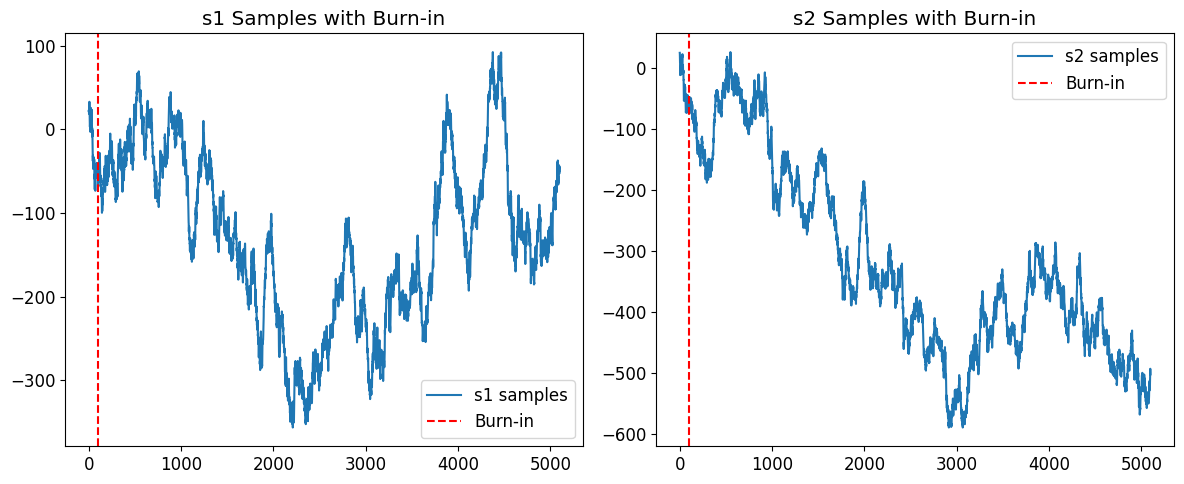

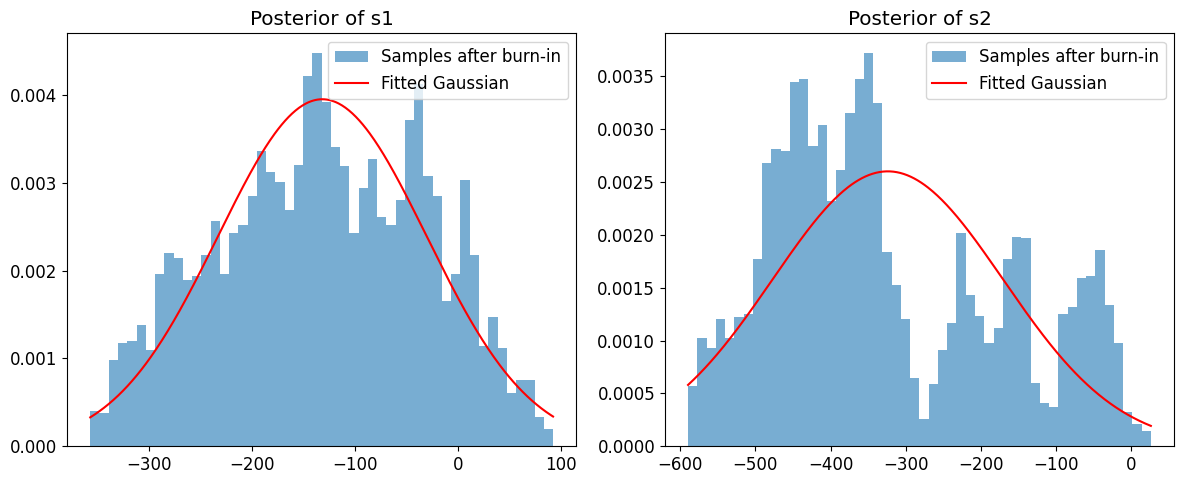

In [85]:
# Plot to observe the burn-in
def plot_burn_in(s1_samples, s2_samples, burn_in):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].plot(s1_samples, label="s1 samples")
    ax[0].axvline(burn_in, color='red', linestyle='--', label="Burn-in")
    ax[0].set_title("s1 Samples with Burn-in")
    ax[0].legend()
    
    ax[1].plot(s2_samples, label="s2 samples")
    ax[1].axvline(burn_in, color='red', linestyle='--', label="Burn-in")
    ax[1].set_title("s2 Samples with Burn-in")
    ax[1].legend()
    
    plt.tight_layout()
    plt.show()

# Plot histogram of samples with fitted Gaussian
def plot_histogram_with_fitted_gaussian(samples, title, ax):
    mu = np.mean(samples)
    sigma = np.std(samples)
    ax.hist(samples, bins=50, density=True, alpha=0.6, label="Samples after burn-in")
    ax.plot(np.linspace(min(samples), max(samples), 400), 
            norm.pdf(np.linspace(min(samples), max(samples), 400), mu, sigma), 
            'r', label="Fitted Gaussian")
    ax.legend()
    ax.set_title(title)

# Run the Gibbs sampler and visualize the results
params = initialize_parameters()
burn_in = 100
num_samples = 5000
s1_samples, s2_samples = gibbs_sampling(num_samples, burn_in, params)

# Plot to observe the burn-in
plot_burn_in(s1_samples, s2_samples, burn_in)

# Plot histograms for s1 and s2
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_histogram_with_fitted_gaussian(s1_samples[burn_in:], "Posterior of s1", ax[0])
plot_histogram_with_fitted_gaussian(s2_samples[burn_in:], "Posterior of s2", ax[1])
plt.tight_layout()
plt.show()